In [1]:
# import the necessary packages
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import pandas as pd
import os

## Check data

In [2]:
train_dir = "../data/train"

CATEGORIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common-Chickweed', 'Common-wheat', 'Fat-Hen', 'Loose-Silky-bent',
              'Maize', 'Scentless-Mayweed', 'Shepherds-Purse', 'Small-flowered-Cranesbill', 'Sugar-beet']

# check numbers of categories
NumCatergories = len(CATEGORIES)
print("Numbers of categories:", NumCatergories)

# check numbers of images
for category in CATEGORIES:
    print('{}: {} images'.format(category, len(os.listdir(os.path.join(train_dir, category)))))

Numbers of categories: 12
Black-grass: 168 images
Charlock: 243 images
Cleavers: 176 images
Common-Chickweed: 393 images
Common-wheat: 151 images
Fat-Hen: 288 images
Loose-Silky-bent: 426 images
Maize: 141 images
Scentless-Mayweed: 331 images
Shepherds-Purse: 157 images
Small-flowered-Cranesbill: 316 images
Sugar-beet: 250 images


In [3]:
# creat a dataframe including filename_path, catagory and id
train = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        train.append(['../data/train/{}/{}'.format(category, file), category, category_id])
        
train = pd.DataFrame(train, columns=['file', 'category','category_id'])
print("The shape of train: ", train.shape)
train.head(2)

The shape of train:  (3040, 3)


,file,category,category_id
0,../data/train/Black-grass/39e9bf4c7.png,Black-grass,0
1,../data/train/Black-grass/075d004bc.png,Black-grass,0


## Example images

In [4]:
def read_img(filepath, size = (224,224)):
    img = cv2.imread(filepath)
    img = cv2.resize(img, size)
    return img

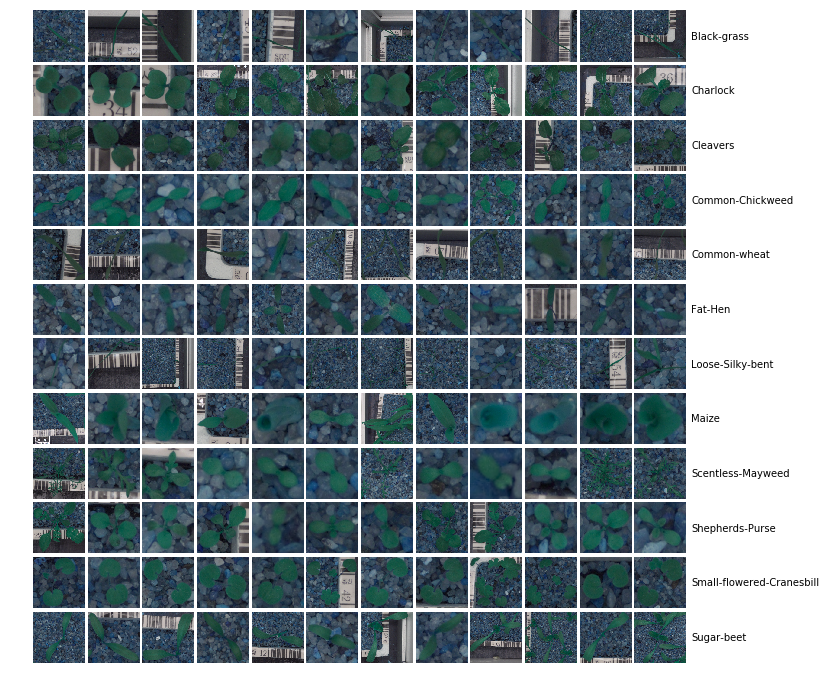

In [5]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(1, figsize=(NumCatergories, NumCatergories))
grid = ImageGrid(fig, 111, nrows_ncols=(NumCatergories, NumCatergories), axes_pad=0.05)

i = 0
for category_id, category in enumerate(CATEGORIES):
    for filepath in train[train['category'] == category]['file'].values[:NumCatergories]:
        ax = grid[i]
        img = read_img(filepath)
        ax.imshow(img)
        ax.axis('off')
        if i % NumCatergories == NumCatergories - 1:
            ax.text(250, 112, filepath.split('/')[3], verticalalignment='center')
        i += 1

plt.show()

## Sample traning data

In [6]:
# concat and sample traning data
SAMPLE_PER_CATEGORY = min([len(os.listdir(os.path.join(train_dir, category))) for category in CATEGORIES])
train = pd.concat([train[train['category'] == c][:SAMPLE_PER_CATEGORY] for c in CATEGORIES])
train = train.sample(frac=1)   ##shuffle
train.index = np.arange(len(train))
print(train.shape)
train.head(2)

(1692, 3)


,file,category,category_id
0,../data/train/Black-grass/7f84c8699.png,Black-grass,0
1,../data/train/Charlock/5b8301d7f.png,Charlock,1


## Define pre-processing function

In [7]:
def extract_BGR_histogram(image):
    """extract a 3D color histogram from the BGR color space using
    the supplied number of `bins` per channel"""
    Hist = []
    for i in range(3):
        hist = cv2.calcHist([image],[i],None,[128],[0,256])
        Hist = np.append(Hist, hist) 

    # return the flattened histogram as the feature vector
    return Hist.flatten()

def extract_HSV_histogram(image):
    """extract a 3D color histogram from the HSV color space using
    the supplied number of `bins` per channel"""
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    Hist = []
    for i in range(3):
        hist = cv2.calcHist([hsv],[i],None,[128],[0,256])
        Hist = np.append(Hist, hist) 

    # return the flattened histogram as the feature vector
    return Hist.flatten()


def extract_HLS_histogram(image):
    """extract a 3D color histogram from the HLS color space using
    the supplied number of `bins` per channel"""
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    Hist = []
    for i in range(3):
        hist = cv2.calcHist([hls],[i],None,[128],[0,256])
        Hist = np.append(Hist, hist) 

    # return the flattened histogram as the feature vector
    return Hist.flatten()


def create_mask_for_plant(image):
    """create a mask for the plants image"""
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask


def segment_plant(image):
    """segement out the plants images using the mask"""
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output


def sharpen_image(image):
    """sharpen image"""
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

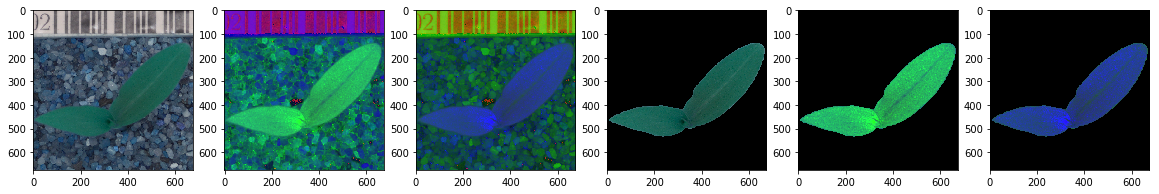

In [8]:
# read full images
img_eg = cv2.imread('../data/train/Maize/1d8e6686f.png')
hsv_eg = cv2.cvtColor(img_eg, cv2.COLOR_BGR2HSV)
hls_eg = cv2.cvtColor(img_eg,cv2.COLOR_BGR2HLS)

# mask out images
image_segmented = segment_plant(img_eg)
image_segmented_hls = cv2.cvtColor(image_segmented,cv2.COLOR_BGR2HLS)
image_segmented_hsv = cv2.cvtColor(image_segmented,cv2.COLOR_BGR2HSV)

# show images
fig, axs = plt.subplots(1, 6, figsize=(20, 20))
axs[0].imshow(img_eg)
axs[1].imshow(hsv_eg)
axs[2].imshow(hls_eg)
axs[3].imshow(sharpen_image(image_segmented))
axs[4].imshow(sharpen_image(image_segmented_hsv))
axs[5].imshow(sharpen_image(image_segmented_hls))

## Load images

In [9]:
# initialize the raw pixel intensities matrix, the features matrix,
# and labels list
BGRImages = []
HSVImages = []
HLSImages = []
his_BGR = []
his_HSV = []
his_HLS = []
his_mask_BGR = []
his_mask_HSV = []
his_mask_HLS = []
labels = []

# loop over the input images
for i, row in train.iterrows():
    # load the image and extract the class label
    # our images were named as labels.image_number.format
    image = cv2.imread(row['file'])
    # get the labels from the name of the images by extract the string before "."
    label = row['category_id']

    # extract raw pixel intensity "features"
    #followed by a color histogram to characterize the color distribution of the pixels
    # in the image
    
    resize_image = cv2.resize(image, (128, 128))
    bgrimage = resize_image.flatten()
    hsvimage = cv2.cvtColor(resize_image, cv2.COLOR_BGR2HSV).flatten()
    hlsimage = cv2.cvtColor(resize_image, cv2.COLOR_BGR2HLS).flatten()
    
    his_bgr = extract_BGR_histogram(resize_image)
    his_hsv = extract_HSV_histogram(resize_image)
    his_hls = extract_HLS_histogram(resize_image)
    
    image_mask = create_mask_for_plant(resize_image)
    image_mask_sharpen = sharpen_image(segment_plant(resize_image))
    his_mask_bgr = extract_BGR_histogram(image_mask_sharpen)
    his_mask_hsv = extract_HSV_histogram(image_mask_sharpen)
    his_mask_hls = extract_HLS_histogram(image_mask_sharpen)

    # add the messages we got to the raw images, features, and labels matricies
    BGRImages.append(bgrimage)
    HSVImages.append(hsvimage)
    HLSImages.append(hlsimage)
    his_BGR.append(his_bgr)
    his_HSV.append(his_hsv)
    his_HLS.append(his_hls)
    his_mask_BGR.append(his_mask_bgr)
    his_mask_HSV.append(his_mask_hsv)
    his_mask_HLS.append(his_mask_hls)
    labels.append(label)    

    # show an update every 200 images until the last image
    if i > 0 and ((i + 1)% 200 == 0 or i == train.shape[0]-1):
        print("[INFO] processed {}/{}".format(i+1, train.shape[0]))

[INFO] processed 200/2652
[INFO] processed 400/2652
[INFO] processed 600/2652
[INFO] processed 800/2652
[INFO] processed 1000/2652
[INFO] processed 1200/2652
[INFO] processed 1400/2652
[INFO] processed 1600/2652
[INFO] processed 1800/2652
[INFO] processed 2000/2652
[INFO] processed 2200/2652
[INFO] processed 2400/2652
[INFO] processed 2600/2652
[INFO] processed 2652/2652


In [10]:
# show some information on the memory consumed by the raw images
# matrix and features matrix
BGRImages = np.array(BGRImages)
HSVImages = np.array(HSVImages)
HLSImages = np.array(HLSImages)
his_BGR = np.array(his_BGR)
his_HSV = np.array(his_HSV)
his_HLS = np.array(his_HLS)
his_mask_BGR = np.array(his_mask_BGR)
his_mask_HSV = np.array(his_mask_HSV)
his_mask_HLS = np.array(his_mask_HLS)
labels = np.array(labels)

print("[INFO] BGRImages matrix: {:.2f}MB".format(
    BGRImages.nbytes / (1024 * 1000.0)))
print("[INFO] his_BGR matrix: {:.2f}MB".format(
    his_BGR.nbytes / (1024 * 1000.0)))
print("[INFO] his_mask_BGR matrix: {:.2f}MB".format(
    his_mask_BGR.nbytes / (1024 * 1000.0)))

[INFO] BGRImages matrix: 127.30MB
[INFO] his_BGR matrix: 7.96MB
[INFO] his_mask_BGR matrix: 7.96MB


## KNN

In [11]:
# partition the data into training and testing splits, using 85%
# of the data for training and the remaining 15% for testing
(trainRI, testRI, trainRL, testRL) = train_test_split(
    BGRImages, labels, test_size=0.15, random_state=27)
(trainVI, testVI, trainVL, testVL) = train_test_split(
    HSVImages, labels, test_size=0.15, random_state=27)
(trainSI, testSI, trainSL, testSL) = train_test_split(
    HLSImages, labels, test_size=0.15, random_state=27)

(trainHBI, testHBI, trainHBL, testHBL) = train_test_split(
    his_BGR, labels, test_size=0.15, random_state=27)
(trainHVI, testHVI, trainHVL, testHVL) = train_test_split(
    his_HSV, labels, test_size=0.15, random_state=27)
(trainHSI, testHSI, trainHSL, testHSL) = train_test_split(
    his_HLS, labels, test_size=0.15, random_state=27)

(trainHMBI, testHMBI, trainHMBL, testHMBL) = train_test_split(
    his_mask_BGR, labels, test_size=0.15, random_state=27)
(trainHMVI, testHMVI, trainHMVL, testHMVL) = train_test_split(
    his_mask_HSV, labels, test_size=0.15, random_state=27)
(trainHMSI, testHMSI, trainHMSL, testHMSL) = train_test_split(
    his_mask_HLS, labels, test_size=0.15, random_state=27)

### Different Color Space Raw pixels

In [12]:
# k-NN BGR
NeigborsNum = 9
print("[INFO] evaluating BGRImages accuracy...")
model = KNeighborsClassifier(n_neighbors= NeigborsNum)
model.fit(trainRI, trainRL)
acc = model.score(testRI, testRL)
print("[INFO] k-NN classifier: k={}".format(NeigborsNum))
print("[INFO] BGRImages accuracy: {:.2f}%".format(acc * 100))

[INFO] evaluating BGRImages accuracy...
[INFO] k-NN classifier: k=9
[INFO] BGRImages accuracy: 18.59%


In [13]:
# k-NN HSV
print("[INFO] evaluating HSVImages accuracy...")
model = KNeighborsClassifier(n_neighbors= NeigborsNum)
model.fit(trainVI, trainVL)
acc = model.score(testVI, testVL)
print("[INFO] k-NN classifier: k={}".format(NeigborsNum))
print("[INFO] HSVImages accuracy: {:.2f}%".format(acc * 100))

[INFO] evaluating HSVImages accuracy...
[INFO] k-NN classifier: k=9
[INFO] HSVImages accuracy: 31.91%


In [14]:
# k-NN HLS
print("[INFO] evaluating HLSImages accuracy...")
model = KNeighborsClassifier(n_neighbors= NeigborsNum)
model.fit(trainSI, trainSL)
acc = model.score(testSI, testSL)
print("[INFO] k-NN classifier: k={}".format(NeigborsNum))
print("[INFO] HLSImages accuracy: {:.2f}%".format(acc * 100))

[INFO] evaluating HLSImages accuracy...
[INFO] k-NN classifier: k=9
[INFO] HLSImages accuracy: 31.66%


### Different Color Space Histograms

In [15]:
# k-NN BGR_hisogram
print("[INFO] evaluating his_BGR accuracy...")
model = KNeighborsClassifier(n_neighbors= NeigborsNum)
model.fit(trainHBI, trainHBL)
acc = model.score(testHBI, testHBL)
print("[INFO] k-NN classifier: k={}".format(NeigborsNum))
print("[INFO] his_BGR accuracy: {:.2f}%".format(acc * 100))

[INFO] evaluating his_BGR accuracy...
[INFO] k-NN classifier: k=9
[INFO] his_BGR accuracy: 59.05%


In [16]:
# k-NN HSV_hisogram
print("[INFO] evaluating his_HSV accuracy...")
model = KNeighborsClassifier(n_neighbors= NeigborsNum)
model.fit(trainHVI, trainHVL)
acc = model.score(testHVI, testHVL)
print("[INFO] k-NN classifier: k={}".format(NeigborsNum))
print("[INFO] his_HSV accuracy: {:.2f}%".format(acc * 100))

[INFO] evaluating his_HSV accuracy...
[INFO] k-NN classifier: k=9
[INFO] his_HSV accuracy: 66.08%


In [17]:
# k-NN HLS_hisogram
print("[INFO] evaluating his_HLS accuracy...")
model = KNeighborsClassifier(n_neighbors= NeigborsNum)
model.fit(trainHSI, trainHSL)
acc = model.score(testHSI, testHSL)
print("[INFO] k-NN classifier: k={}".format(NeigborsNum))
print("[INFO] his_HLS accuracy: {:.2f}%".format(acc * 100))

[INFO] evaluating his_HLS accuracy...
[INFO] k-NN classifier: k=9
[INFO] his_HLS accuracy: 63.07%


### Different Color Space Mask Histograms

In [18]:
# k-NN BGR_msk_hisogram
print("[INFO] evaluating his_mask_BGR accuracy...")
model = KNeighborsClassifier(n_neighbors= NeigborsNum)
model.fit(trainHMBI, trainHMBL)
acc = model.score(testHMBI, testHMBL)
print("[INFO] k-NN classifier: k={}".format(NeigborsNum))
print("[INFO] his_mask_BGR accuracy: {:.2f}%".format(acc * 100))

[INFO] evaluating his_mask_BGR accuracy...
[INFO] k-NN classifier: k=9
[INFO] his_mask_BGR accuracy: 63.57%


In [19]:
# k-NN HSV_msk_hisogram
print("[INFO] evaluating his_mask_HSV accuracy...")
model = KNeighborsClassifier(n_neighbors= NeigborsNum)
model.fit(trainHMVI, trainHMVL)
acc = model.score(testHMVI, testHMVL)
print("[INFO] k-NN classifier: k={}".format(NeigborsNum))
print("[INFO] his_mask_HSV accuracy: {:.2f}%".format(acc * 100))

[INFO] evaluating his_mask_HSV accuracy...
[INFO] k-NN classifier: k=9
[INFO] his_mask_HSV accuracy: 69.60%


In [20]:
# k-NN HLS_msk_hisogram
print("[INFO] evaluating his_mask_HLS accuracy...")
model = KNeighborsClassifier(n_neighbors= NeigborsNum)
model.fit(trainHMSI, trainHMSL)
acc = model.score(testHMSI, testHMSL)
print("[INFO] k-NN classifier: k={}".format(NeigborsNum))
print("[INFO] his_mask_HLS accuracy: {:.2f}%".format(acc * 100))

[INFO] evaluating his_mask_HLS accuracy...
[INFO] k-NN classifier: k=9
[INFO] his_mask_HLS accuracy: 68.84%


### Hyperparameter K

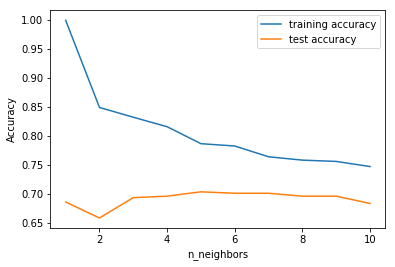

In [21]:
training_accuracy = []
test_accuracy = []
# n_neighbors
neighbors_settings = range(1, 11)

for n_neighbors in neighbors_settings:
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(trainHMVI, trainHMVL)
    training_accuracy.append(clf.score(trainHMVI, trainHMVL))
    test_accuracy.append(clf.score(testHMVI, testHMVL))

plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

## HSV Mask Histograms KNN Model evaluation

In [22]:
from sklearn.metrics import roc_curve, auc 
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report
from sklearn import metrics

In [23]:
# k-NN HSV_msk_hisogram
print("[INFO] evaluating his_mask_HSV accuracy...")

model = KNeighborsClassifier(n_neighbors= NeigborsNum)
model.fit(trainHMVI, trainHMVL)
acc = model.score(testHMVI, testHMVL)
print("[INFO] k-NN classifier: k={}".format(NeigborsNum))
print("[INFO] his_mask_HSV accuracy: {:.2f}%".format(acc * 100))

[INFO] evaluating his_mask_HSV accuracy...
[INFO] k-NN classifier: k=9
[INFO] his_mask_HSV accuracy: 69.60%


In [24]:
print(classification_report(testHMVL, model.predict(testHMVI)))

              precision    recall  f1-score   support

           0       0.38      0.48      0.43        27
           1       0.68      0.81      0.74        26
           2       0.72      0.87      0.79        30
           3       0.71      0.82      0.76        33
           4       0.76      0.88      0.82        33
           5       0.61      0.74      0.67        23
           6       0.75      0.41      0.53        44
           7       0.92      0.73      0.81        45
           8       0.77      0.87      0.81        38
           9       0.63      0.53      0.58        32
          10       0.71      0.62      0.67        32
          11       0.66      0.66      0.66        35

   micro avg       0.70      0.70      0.70       398
   macro avg       0.69      0.70      0.69       398
weighted avg       0.71      0.70      0.69       398



In [25]:
y_score = model.predict_proba(testHMSI)

In [26]:
y_score[0:4]

array([[0.11111111, 0.        , 0.        , 0.66666667, 0.        ,
        0.11111111, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.11111111],
       [0.        , 0.        , 0.        , 0.11111111, 0.        ,
        0.22222222, 0.        , 0.22222222, 0.        , 0.11111111,
        0.22222222, 0.11111111],
       [0.        , 0.        , 0.        , 0.66666667, 0.        ,
        0.        , 0.        , 0.33333333, 0.        , 0.        ,
        0.        , 0.        ],
       [0.11111111, 0.        , 0.        , 0.        , 0.        ,
        0.11111111, 0.        , 0.        , 0.33333333, 0.        ,
        0.        , 0.44444444]])

In [27]:
testHMVL = label_binarize(testHMVL, np.arange(12))
testHMVL[0:4]

array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [1]:
print ('调用函数auc：', metrics.roc_auc_score(testHMVL, y_score, average='micro'))

NameError: name 'metrics' is not defined

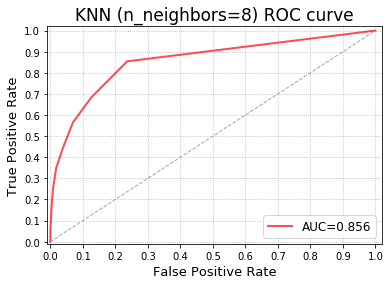

In [29]:
fpr, tpr, thresholds = metrics.roc_curve(testHMVL.ravel(),y_score.ravel())
auc = metrics.auc(fpr, tpr)
#FPR就是横坐标,TPR就是纵坐标
plt.plot(fpr, tpr, c = 'r', lw = 2, alpha = 0.7, label = u'AUC=%.3f' % auc)
plt.plot((0, 1), (0, 1), c = '#808080', lw = 1, ls = '--', alpha = 0.7)
plt.xlim((-0.01, 1.02))
plt.ylim((-0.01, 1.02))
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.grid(b=True, ls=':')
plt.legend(loc='lower right', fancybox=True, framealpha=0.8, fontsize=12)
plt.title(u'KNN (n_neighbors=8) ROC curve', fontsize=17)
plt.show() 

In [32]:
def foo(args):
    x=1
    print (locals())
    
foo(123)

{'x': 1, 'args': 123}
